# Project 2: Anime Sales Prediction

With our data scraped and cleaned, we move on to the building the actual model.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

from scipy import stats

sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.5)

In [11]:
data_df = pd.read_pickle("../data/anime_sales_df_v3.pickle")
data_df.columns, len(data_df)

(Index(['title', 'year', 'season_qtr', 'avg_sales', 're_rls', 'total',
        'gross_1st_rls', 'studio', 'source', 'episode', 'broadcast', 'genre',
        'duration', 'rating', 'score', 'member', 'favorite', 'day', 'time',
        'hour', 'runtime', 'Game', 'Sci-Fi', 'Adventure', 'Mystery', 'Magic',
        'Fantasy', 'Comedy', 'Shounen', 'Drama', 'Action', 'Mecha', 'Seinen',
        'Demons', 'Josei', 'Military', 'Ecchi', 'Super Power', 'Supernatural',
        'Music', 'Romance', 'School', 'Slice of Life', 'Parody', 'Shoujo',
        'Historical', 'Harem', 'Police', 'Sports', 'Martial Arts',
        'Psychological', 'Shoujo Ai', 'Space', 'Samurai', 'Horror', 'Thriller',
        'Vampire', 'Shounen Ai', 'Dementia', 'Cars', 'sales'],
       dtype='object'),
 1634)

In [660]:
len(data_df)

1634

## Final dataset adjustments: outliers and infrequent genres

We remove all sales greater than or equal to than 500, and all outliers for score, duration, or members.

In [12]:
data_df = data_df[data_df["sales"] < 500]
data_df = data_df[(np.abs(stats.zscore(data_df[["score", "duration", "member"]])) < 2).all(axis=1)]


We remove the two most infrequent genres, which cause issues with variance later on if retained. 

In [13]:
data_df = data_df.drop(labels=["Cars", "Dementia"], axis=1, errors="ignore")
genre_list = np.unique(data_df["genre"].aggregate(sum))
genre_list = np.delete(genre_list, np.where((genre_list == "Cars")|(genre_list == "Dementia")))
len(data_df)

1273

count    1273.000000
mean      106.947447
std       109.850773
min         0.400000
25%        25.400000
50%        67.500000
75%       153.500000
max       491.300000
Name: sales, dtype: float64

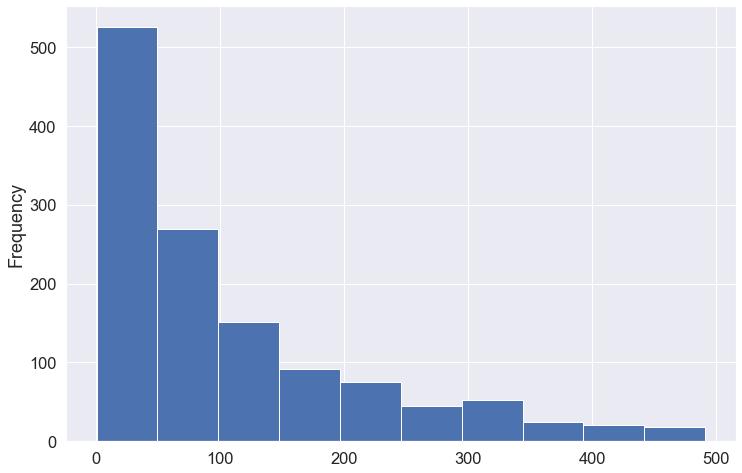

In [14]:
data_df["sales"].plot.hist()
data_df["sales"].describe()

## Constructing a first model

Looks like we removed ~350 data points, leaving us with ~1300. Let's work on grabbing the few most apparently predictive features and turning them into a base model. We can then work on and improve that model with more sophisticating learning techniques and feature engineering.

### Examining feature and predictor correlations

Let's look at the correlations of various features with sales.

In [15]:
data_df.corr()["sales"].sort_values(key=lambda x: abs(x), ascending=False).head(10)

sales       1.000000
score       0.315871
favorite    0.257057
member      0.254360
year       -0.203960
runtime     0.118089
episode     0.113318
Harem       0.108656
hour       -0.097780
Comedy      0.091240
Name: sales, dtype: float64

In [16]:
data_df.drop(labels=genre_list, axis=1).corr()

,year,episode,duration,score,member,favorite,hour,runtime,sales
year,1.000000,-0.293693,-0.105426,-0.007400,0.228062,0.048007,0.212381,-0.302898,-0.203960
episode,-0.293693,1.000000,-0.016714,0.203424,-0.042360,0.115603,-0.007885,0.989304,0.113318
duration,-0.105426,-0.016714,1.000000,-0.030674,0.024854,0.002474,-0.039719,0.114610,0.040531
score,-0.007400,0.203424,-0.030674,1.000000,0.418862,0.483465,-0.120711,0.197562,0.315871
member,0.228062,-0.042360,0.024854,0.418862,1.000000,0.725146,-0.036201,-0.038037,0.254360
favorite,0.048007,0.115603,0.002474,0.483465,0.725146,1.000000,-0.064945,0.113893,0.257057
hour,0.212381,-0.007885,-0.039719,-0.120711,-0.036201,-0.064945,1.000000,-0.014345,-0.097780
runtime,-0.302898,0.989304,0.114610,0.197562,-0.038037,0.113893,-0.014345,1.000000,0.118089
sales,-0.203960,0.113318,0.040531,0.315871,0.254360,0.257057,-0.097780,0.118089,1.000000


Omitting our various genres, it like our strongest potential associations are with score, year, members, and favorites. As might be expected, members and favorites are highly collinear, so let's omit favorites. Let's look at the pair plots for score, year, members, and sales.

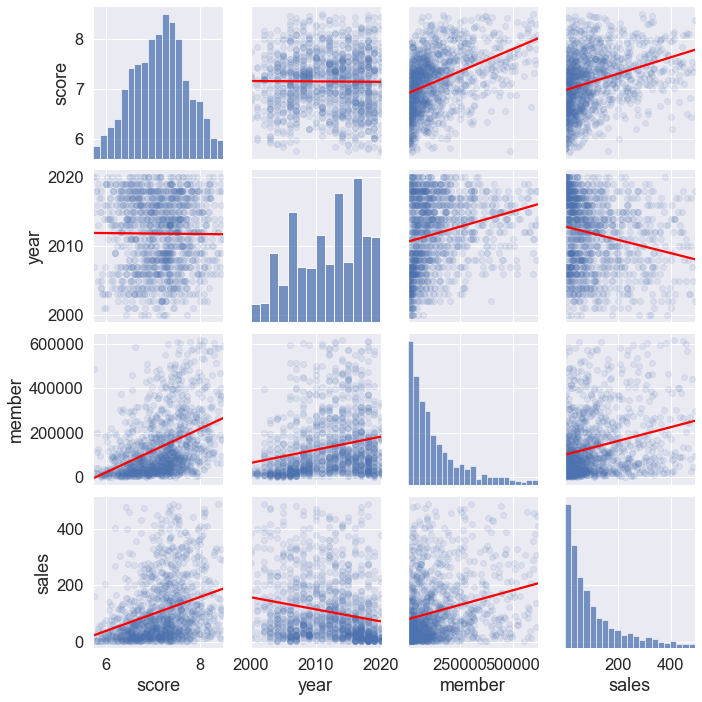

In [665]:
sns.pairplot(data_df[["score", "year", "member", "sales"]], kind="reg", plot_kws={'ci': False, 'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})

We see evidence of some linear relationships between the features and sales, but there's a lot of noise, hence the <0.35 correlations.

### Our train-test split

Let's do a train test split for our final model evaluation. All of our training will be on just the training set.

In [748]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data_df.drop(["sales"], axis=1), data_df["sales"], test_size=.2, random_state=1000)

### Base model: simple linear regression on score, year, and members

We'll do simple linear regression with score, year, and members as features. This will be our baseline, and we'll attempt to improve on it with more complex models.

0.14121852857735562


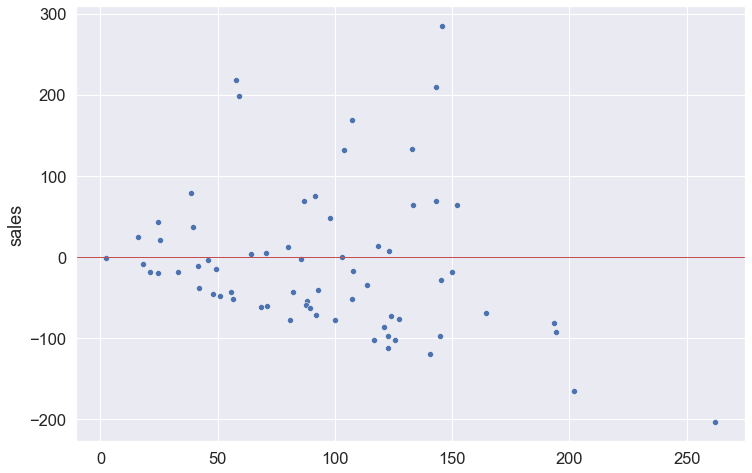

In [814]:
features = ["score", "member", "year"]
X_trainval_dum = pd.get_dummies(X_trainval[features])

train_scores = []
val_scores = []

kf = KFold(n_splits=15, shuffle=True, random_state=1000)

for train_idx, val_idx in kf.split(X_trainval_dum):
    lm = LinearRegression()
    X_train, X_val = X_trainval_dum.iloc[train_idx], X_trainval_dum.iloc[val_idx]
    y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]
    lm.fit(X_train, y_train)
    y_val_predict = lm.predict(X_val)
    train_scores.append(lm.score(X_train, y_train))
    val_scores.append(lm.score(X_val, y_val))

print("Cross-validation score:", np.mean(val_scores))
    
# residual plot for the last train/val split
sns.scatterplot(x=y_val_predict, y=y_val-y_val_predict)
plt.axhline(linewidth=1, color='r');

We see that the residuals don't seem consistently positive or negative, though they do seem more spread out as the predicted value increases. Worth keeping an eye on to see whether our improved model deals with this issue.

## Ridge and Lasso Regression

### Function Definition

Now let's move to more advanced techniques. We define ridge and lasso functions.

In [815]:
def ridge_regress(features, scale=True, seed=1000):    
    X_trainval_dum = pd.get_dummies(X_trainval[features])

    X_train = X_trainval_dum
    y_train = y_trainval
    
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)

    kf = KFold(n_splits=15, shuffle=True, random_state=seed)

    lm = RidgeCV(cv=kf, alphas=np.arange(0.1, 100, 1))
    lm.fit(X_train, y_train)

    train_score = lm.score(X_train, y_train)
    cv_score = lm.best_score_
    
    return lm, cv_score, scaler

In [816]:
def lasso_regress(features, scale=True, polynomial=False, int_only=False, degree=2, seed=1000):    
    X_trainval_dum = pd.get_dummies(X_trainval[features])

    X_train = X_trainval_dum
    y_train = y_trainval
    
    if polynomial:
        poly = PolynomialFeatures(degree, interaction_only=int_only)
        X_train = poly.fit_transform(X_train)
        print("Poly input features:", poly.n_input_features_)
        print("Poly output features:", poly.n_output_features_)
    if scale:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
    

    kf = KFold(n_splits=15, shuffle=True, random_state=seed)

    lm = LassoCV(cv=kf, max_iter = 20000)
    lm.fit(X_train, y_train)

    train_score = lm.score(X_train, y_train)
    
    # Calculate the cross-validation score as r2, so as to be comparable to other
    # r2 measures produced in this project. 
    cv_score = 1-np.mean(lm.mse_path_, axis=1).min()/np.var(y_train)
    
    return lm, cv_score, scaler

### Ridge and Lasso Preliminary Tests

Let's try Ridge and Lasso regression on the dataset now and compare our results to OLS regression.

In [817]:
features = ["score", "year", "member"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print("Ridge CV R2:", cv_score_r)
print("Lasso CV R2:", cv_score_l)

Ridge CV R2: 0.14233370738235868
Lasso CV R2: 0.16503064355765085


Our ridge and lasso scores are very slightly better than our OLS validation score, suggesting that overfitting is not a huge issue with only these 3 regressors. Let's start adding in more features.

In [818]:
features = ["score", "year", "member", "rating"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.15016649400364687 0.17404782603557223


Adding in rating improves our score somewhat.

In [819]:
features = ["score", "year", "member", "rating", "day"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.14111704404563655 0.16834954213003117


In [820]:
features = ["score", "year", "member", "rating", "season_qtr"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.14611015574007122 0.1726554683126046


In [821]:
features = ["score", "year", "member", "rating", "day", "season_qtr"]

lm_r, cv_score_r, _ = ridge_regress(features)
lm_l, cv_score_l, _ = lasso_regress(features)
print(cv_score_r, cv_score_l)

0.1370475190215791 0.16768554421970627


### Day and Season as non-predictive, variance-inducing features

Looks like adding in the season (Spring, Summer, Fall, Winter) and day of the week (Monday to Sunday) as features actually hurts our model. Perhaps any information provided by these features doesn't make up for any overfitting, and/or any relationship suggested by the feature exhibits high variance.

                  mean         std
season_qtr                        
Fall        114.746087  114.517872
Spring      109.333333  109.984039
Summer      104.353512  111.031085
Winter       96.912727  101.838193


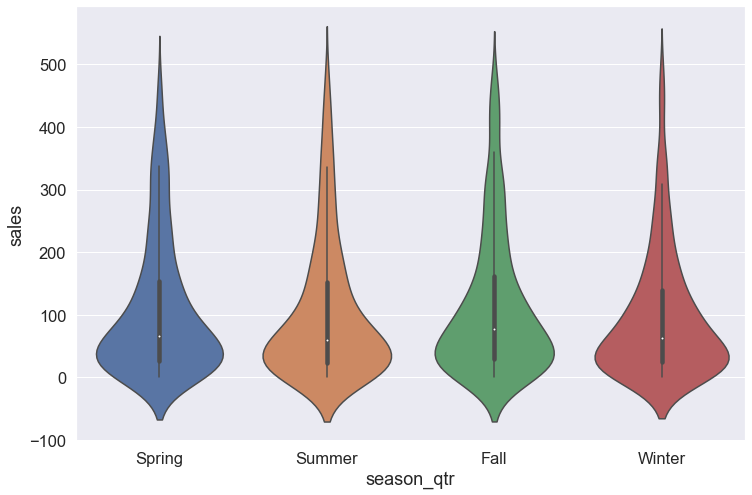

In [822]:
print(data_df.groupby("season_qtr")["sales"].agg(['mean', 'std']))
sns.violinplot(data=data_df, x="season_qtr", y="sales", order=["Spring", "Summer", "Fall", "Winter"]);

                 mean         std
day                              
Friday     100.861491  113.484115
Monday      94.416092  109.344609
Saturday    84.725397   90.090623
Sunday     112.459420  114.986233
Thursday    92.844330  103.992115
Tuesday    118.823636  124.759480
Wednesday   94.297143  108.253219


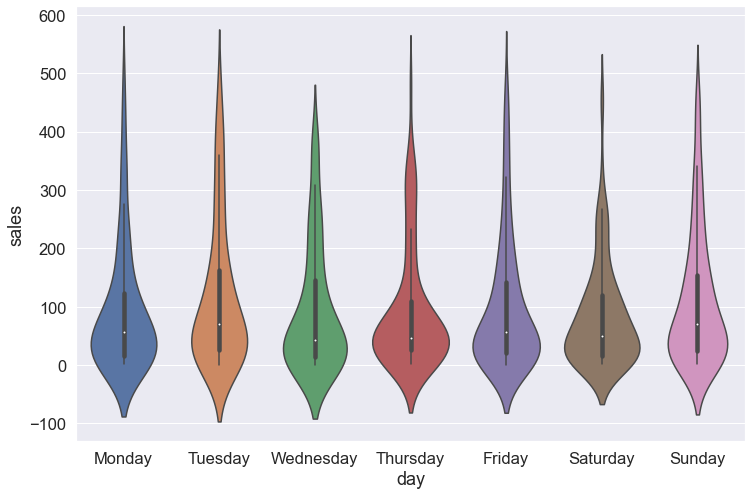

In [823]:
print(data_df.groupby("day")["sales"].agg(['mean', 'std']))
sns.violinplot(data=data_df, x="day", y="sales", order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

So it looks like season/day are barely predictive at all, and the variance within each category of each feature is such the k-folds cross-validation split score may have been dragged down by variance within the season-sales/day-sales relationship over the train/validation splits.


### Polynomial Regression

Now let's try out polynomial regression. Additionally, we'll use only lasso from now on as it has been consistently better and should perform well as the feature count rises.

In [824]:
features = ["score", "year", "member", "rating"]

lm_l, cv_score_l, scaler_l = lasso_regress(features, polynomial=True)
print(cv_score_l)

Poly input features: 8
Poly output features: 45
0.18066324517242072


At least for this set of features, polynomial regression with degree 2 does rather poorly, suggesting that there is no strong polynomial relationship or interaction among these features.

## Genre Feature Engineering


Now let's add genre. Additionally, we'll use only lasso from now on as it has been consistently better.

In [825]:
features = ["score", "year", "member", "rating"]
features.extend(genre_list)

lm_l, cv_score_l, scaler_l = lasso_regress(features)
print(cv_score_l)


0.21307569125202674


It looks like genre helps us a fair bit out of the box, even though there may be a lot of collinearity, and we have a lot of rarely-seen genres at the end that may be causing excessive variance. We'd like to pare down the list somewhat and/or reduce collinearity.

In [826]:
genres_by_frequency = data_df[genre_list].agg(sum).sort_values(ascending=False)
genres_by_frequency

Comedy           625.0
Action           434.0
Romance          399.0
School           358.0
Drama            343.0
Fantasy          300.0
Supernatural     256.0
Sci-Fi           246.0
Slice of Life    242.0
Shounen          229.0
Ecchi            180.0
Adventure        172.0
Seinen           163.0
Magic            138.0
Harem            136.0
Mystery          119.0
Mecha             96.0
Historical        84.0
Super Power       75.0
Shoujo            71.0
Demons            69.0
Military          62.0
Psychological     61.0
Sports            58.0
Music             51.0
Parody            41.0
Horror            38.0
Game              37.0
Martial Arts      34.0
Space             33.0
Josei             29.0
Samurai           29.0
Shoujo Ai         27.0
Vampire           27.0
Thriller          17.0
Police            17.0
Shounen Ai        16.0
dtype: float64

### Genres: Top X Approach

As a simple approach, let's consider keeping the top x genres.

In [827]:
def top_genres(num):
    return genres_by_frequency.head(num).index.tolist()

Maximum score occurs at: 28
Maximum score is: 0.2168498866556796


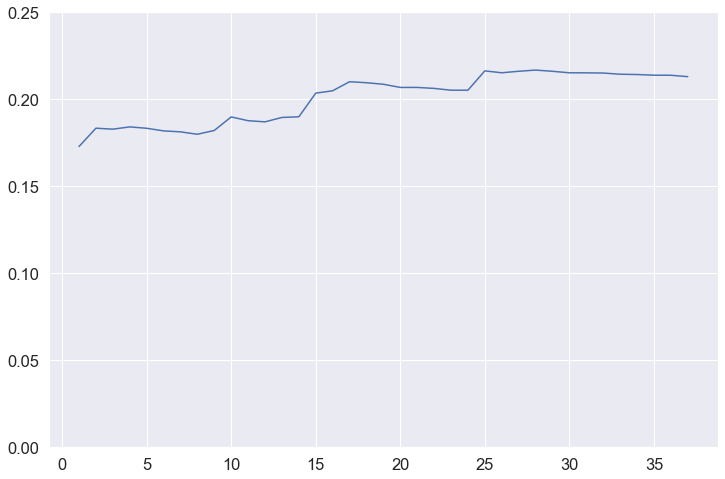

In [828]:
features = ["score", "year", "member", "rating"]

cv_scores = []

for num in range(1, len(genre_list)+1):
    features_mod = np.concatenate([features, top_genres(num)])
    _, cv_score_l, _ = lasso_regress(features_mod)
    cv_scores.append(cv_score_l)

print("Maximum score occurs at:", np.argmax(cv_scores)+1)
print("Maximum score is:", np.max(cv_scores))
g = sns.lineplot(x=range(1, len(genre_list)+1), y=cv_scores)
g.set_ylim(0, 0.25);

We see a peak at 28 genres.

There might be a better subset of genres, though. We could try forward subset selection.

### Genres: Forward Subset Selection

In [829]:
features = ["score", "year", "member", "rating"]

_, original_cv_score, _ = lasso_regress(features)

selection_cv_scores = [original_cv_score]

selected_genres = []
current_genre = None
genres_left = list(genre_list)

while True:
    best_score = selection_cv_scores[-1]
    best_genre = None
    for genre in genres_left:
        current_genre = genre
        new_features = np.concatenate([features, selected_genres, [current_genre]])
        _, cv_score_l, _ = lasso_regress(new_features)
        
        if cv_score_l > best_score:
            best_score = cv_score_l
            best_genre = genre
            
    if best_genre:
        selection_cv_scores.append(best_score)
        selected_genres.append(best_genre)
        genres_left.remove(best_genre)
    else:
        break
        
print("Score progression:", list(zip(list(["None"] + selected_genres), selection_cv_scores)))
print("Best score:", selection_cv_scores[-1])

Score progression: [('None', 0.17404782603557223), ('Harem', 0.18499291305936216), ('Action', 0.19679852508044093), ('Music', 0.20589561715661286), ('Shounen', 0.2127389638656051), ('Mecha', 0.21869366813526991), ('Slice of Life', 0.22383485487061539), ('Horror', 0.22579076517463403), ('Magic', 0.22685398317801841), ('Comedy', 0.22787645092750441), ('Game', 0.22898371670799877), ('Seinen', 0.22943176102329588)]
Best score: 0.22943176102329588


We added fewer genres than before (11) but we've seen an improvement in R2: subset selection worked better than simply naively taking the top X genres.

(0.15, 0.25)

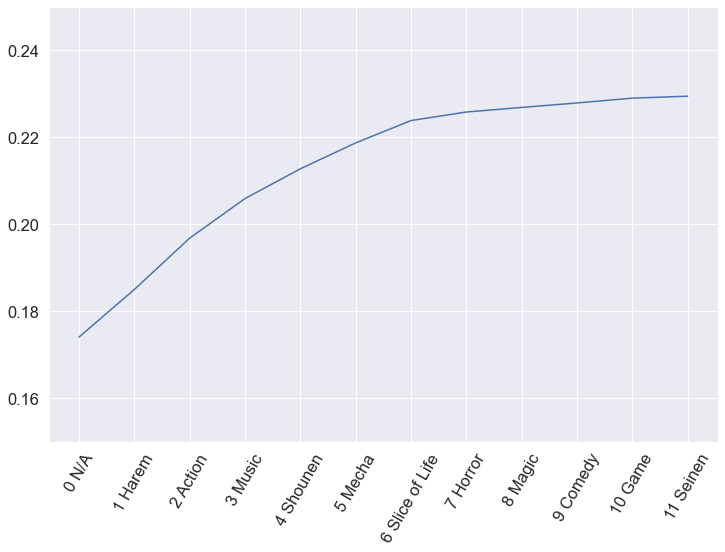

In [831]:
g = sns.lineplot(x=range(len(selection_cv_scores)), y=selection_cv_scores)
selected_genres_add_na = np.concatenate([["N/A"], selected_genres])
labels = [str(i) + " " + selected_genres_add_na[i] for i in range(len(selected_genres_add_na))]
g.set_xticks(range(len(selected_genres_add_na)))
g.set_xticklabels(labels, rotation=60)
g.set_ylim(0.15, 0.25)

### Best solution thus far

Before we do any more complex feature engineering, let's note our preliminary set of best features.

In [834]:
best_features = np.concatenate([["score", "year", "member", "rating"], selected_genres])
best_features

array(['score', 'year', 'member', 'rating', 'Harem', 'Action', 'Music',
       'Shounen', 'Mecha', 'Slice of Life', 'Horror', 'Magic', 'Comedy',
       'Game', 'Seinen'], dtype='<U13')

### Genres: PCA

Let's try PCA on genres.

In [835]:
genre_columns = X_trainval[genre_list]

# let's precalculate all the components
pca = PCA(len(genre_list))
decomp = pca.fit_transform(genre_columns)
pca_cols = ["pc_" + str(i) for i in range(1, len(genre_list)+1)]
X_trainval = pd.concat([X_trainval, pd.DataFrame(decomp, columns=pca_cols, index = X_trainval.index)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(pca.transform(X_test[genre_list]), columns=pca_cols, index=X_test.index)], axis=1)

Maximum score occurs at: 26
Maximum score is: 0.21182594596319204


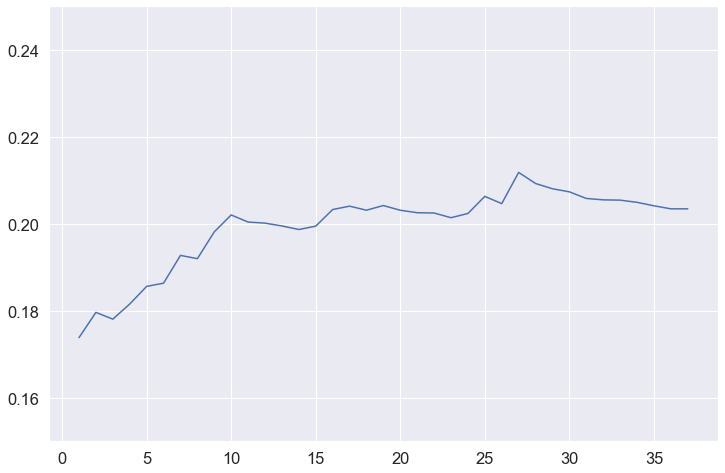

In [836]:
features = ["score", "year", "member", "rating"]

cv_scores = []

for num in range(1, len(genre_list)+1):
    features_mod = np.concatenate([features, pca_cols[:num]])
    _, cv_score_l, _ = lasso_regress(features_mod)
    cv_scores.append(cv_score_l)

print("Maximum score occurs at:", np.argmax(cv_scores))
print("Maximum score is:", np.max(cv_scores))
g = sns.lineplot(x=range(1, len(genre_list)+1), y=cv_scores)
g.set_ylim(0.15, 0.25);

We actually did slightly worse than the top X method. This might be because the variance in the data aren't necessarily best explained best by the top principal components in that specific order. Let's try our forward selection method.

### Genres: PCA & Forward Selection

In [837]:
features = ["score", "year", "member", "rating"]

_, original_cv_score, _ = lasso_regress(features)

selection_cv_scores = [original_cv_score]

selected_comps = []
current_comp = None
comps_left = list(pca_cols)

while True:
    best_score = selection_cv_scores[-1]
    best_comp = None
    for comp in comps_left:
        current_comp = comp
        new_features = np.concatenate([features, selected_comps, [current_comp]])
        _, cv_score_l, _ = lasso_regress(new_features)
        
        if cv_score_l > best_score:
            best_score = cv_score_l
            best_comp = comp
            
    if best_comp:
        selection_cv_scores.append(best_score)
        selected_comps.append(best_comp)
        comps_left.remove(best_comp)
    else:
        break
        
print("Score progression:", list(zip(list(["None"] + selected_comps), selection_cv_scores)))
print("Best score:", selection_cv_scores[-1])

Score progression: [('None', 0.17404782603557223), ('pc_9', 0.18247650771781576), ('pc_27', 0.18983782492076529), ('pc_7', 0.19498783220755556), ('pc_2', 0.200087104486102), ('pc_5', 0.20488775469330134), ('pc_25', 0.20916754708993301), ('pc_16', 0.21306618130372557), ('pc_10', 0.2161487921774008), ('pc_4', 0.2188068146375166), ('pc_19', 0.22052193250419128), ('pc_6', 0.221821527818151), ('pc_24', 0.22283823858142515), ('pc_15', 0.22370166991121176), ('pc_17', 0.22438800961068373)]
Best score: 0.22438800961068373


We did slightly better than the top X genre approach but slightly worse than the forward selection genre approach. It would be interesting to evaluate whether an exhaustive subset search or a more sophisticated selection algorithm, e.g. recursive feature elimination, would do better on genres or genre principal components.

(0.15, 0.25)

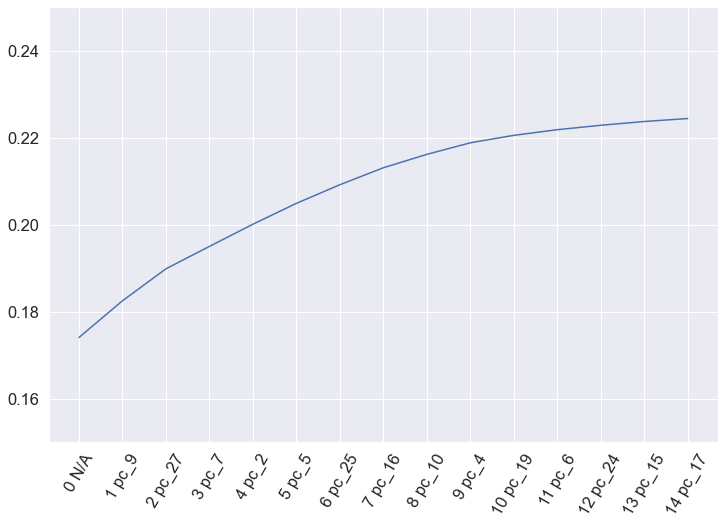

In [839]:
g = sns.lineplot(x=range(len(selection_cv_scores)), y=selection_cv_scores)
selected_comps_add_na = np.concatenate([["N/A"], selected_comps])
labels = [str(i) + " " + selected_comps_add_na[i] for i in range(len(selected_comps_add_na))]
g.set_xticks(range(len(selected_comps_add_na)))
g.set_xticklabels(labels, rotation=60)
g.set_ylim(0.15, 0.25)

### Genres: K-means clustering

Let's try a different approach to genre: K-means.

In [840]:
def cluster_genres(clusters, by_pca=False, comps_to_use=None):
    cluster_by = genre_list if not by_pca else comps_to_use
    cluster_cols = X_trainval[cluster_by]
    
    kmeans = KMeans(n_clusters = clusters, random_state=50, n_init = 50, max_iter = 500)
    kmeans.fit(cluster_cols)
    
    X_trainval["genre_cluster"] = kmeans.predict(cluster_cols)
    X_test["genre_cluster"] = kmeans.predict(X_test[cluster_by])

Maximum score occurs at: 2
Maximum score is: 0.1874402122317368


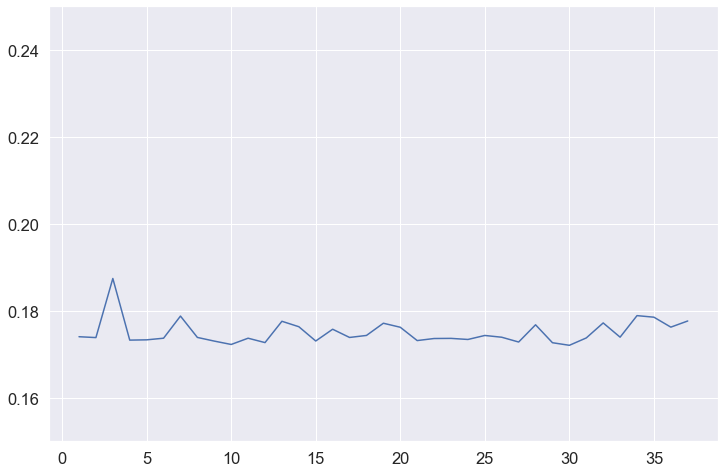

In [841]:
features = ["score", "year", "member", "rating", "genre_cluster"]

cv_scores = []

for num in range(1, len(genre_list)+1):
    cluster_genres(num)
    #features_mod = np.concatenate([features, pca_cols[:num]])
    _, cv_score_l, _ = lasso_regress(features)
    cv_scores.append(cv_score_l)

print("Maximum score occurs at:", np.argmax(cv_scores))
print("Maximum score is:", np.max(cv_scores))
g = sns.lineplot(x=range(1, len(genre_list)+1), y=cv_scores)
g.set_ylim(0.15, 0.25);

We did rather poorly here. Let's see if clustering based on principal components works any better. We need to select the number of principal components to cluster on this time; let's do it in order of component selection from the previous approach.

### Genres: Clustering by principal components

In [842]:
features = ["score", "year", "member", "rating", "genre_cluster"]

cv_scores_cluster_pca = {}

for comps in range(1, len(selected_comps)+1):
    cv_scores_one_comp = []
    for clusters in range(1, len(genre_list)+1):
        cluster_genres(clusters, by_pca=True, comps_to_use=selected_comps[:comps])
    
        _, cv_score_l, _ = lasso_regress(features)
        cv_scores_one_comp.append(cv_score_l)
    print(max(cv_scores_one_comp))
    cv_scores_cluster_pca[comps] = cv_scores_one_comp

0.18284781844678577
0.1778115051018181
0.18329400293416354
0.18532157604254806
0.18947660203312788
0.1852890388476205
0.1837081552424239
0.18515685751181898
0.19218362451564752
0.18780996477960354
0.1851773673546051
0.188588590387886
0.18005018102905568
0.18578074426006697


Unfortunately this approach doesn't seem to have borne fruit. It would be worth exploring in the future whether this approach has any benefits given slight modifications.

## Revisiting our best model

Our best model in the end has features score, year, number, and rating, as well as 11 selected genres.

In [ ]:
final_features = np.concatenate([["score", "year", "member", "rating"], selected_genres])

lm_final, cv_score, scaler_final = lasso_regress(final_features)

For our final R2 and RMSE test scores we get:

In [845]:
y_predict_final = lm_final.predict(scaler_final.transform(pd.get_dummies(X_test[final_features])))
print("R2 score:", r2_score(y_test, y_predict_final))
print("RMSE:", mean_squared_error(y_test, y_predict_final)**0.5)

R2 score: 0.1753628816258076
RMSE: 94.24507337692978


Suggestive of moderate overfitting, but nonetheless an improvement on our base model.

The coefficients and intercept are:

In [854]:
list(zip(final_features, lm_final.coef_))

[('score', 34.50374668354066),
 ('year', -25.494972229887388),
 ('member', 16.61990037683603),
 ('rating', 15.225107312922976),
 ('Harem', 15.020723179673604),
 ('Action', 12.209639036832474),
 ('Music', -10.185656463530862),
 ('Shounen', 11.996460692025925),
 ('Mecha', 8.78537370973559),
 ('Slice of Life', -4.508931231365988),
 ('Horror', 6.8197907350845055),
 ('Magic', 6.903538907868469),
 ('Comedy', 5.282695821767043),
 ('Game', -4.296320521180958),
 ('Seinen', -0.7296130128638442)]

In [856]:
lm_final.intercept_

107.33988212180749

Plot the residuals:

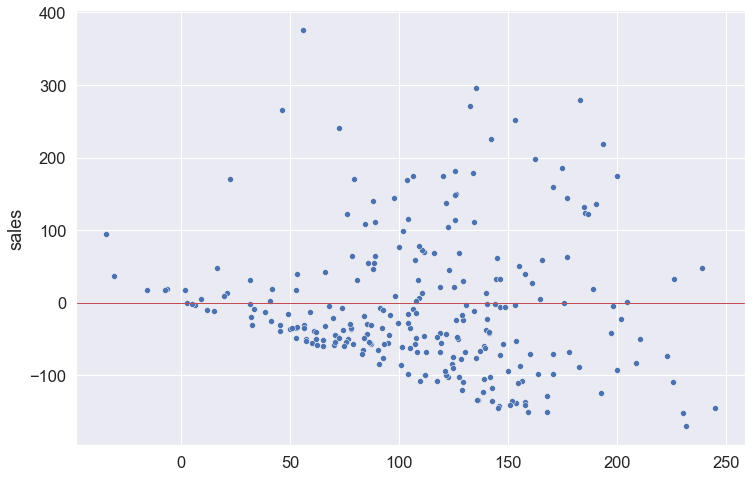

In [857]:
sns.scatterplot(x=y_predict_final, y=y_test-y_predict_final)
plt.axhline(linewidth=1, color='r');

We do continue to see a pattern of more widely-spread residuals with larger predictions. Further work might be done to address this issue.